<a href="https://colab.research.google.com/github/noussayma/ml-student/blob/main/BE_session1_probleme1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problème 1:





Dans ce problème, il s'agit de reconstruire un champ spatialisé cible à partir d'un prédicteur spatialisé et d'observations ponctuelles.  
Dans la première partie, on adapte simplement la procédure de régression pixel à pixel standard au cas où les données cibles ne sont renseignées qu'en quelques pixels (observations "ponctuelles").\
Dans la seconde partie, on entraîne un réseau à prendre les deux types de données, champ spatialisé et observations ponctuelles, en entrée pour reconstruire au mieux la cible complète.

**NB**: Il vaut mieux traiter les deux parties dans l'ordre.

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
! wget https://www.grosfichiers.com/mfh8gy5ZmfB_zaQP9HZKdDk
! mv mfh8gy5ZmfB_zaQP9HZKdDk utile_BE.py

from utile_BE import *

--2024-01-12 13:12:33--  https://www.grosfichiers.com/mfh8gy5ZmfB_zaQP9HZKdDk
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21240 (21K) [application/octet-stream]
Saving to: ‘mfh8gy5ZmfB_zaQP9HZKdDk’

mfh8gy5ZmfB_zaQP9HZ 100%[===================>]  20.74K  --.-KB/s    in 0s      

2024-01-12 13:12:34 (222 MB/s) - ‘mfh8gy5ZmfB_zaQP9HZKdDk’ saved [21240/21240]



## Partie I : régression sur une cible incomplète

La fonction *gen1* permet d'échantillonner des données d'apprentissage.\
Le paramètre *p* représente la proportion de pixels au niveau desquels les observations ponctuelles sont disponibles. Ces observations ponctuelles, contenues dans le deuxième tenseur fourni par *gen1*, sont positives ou nulles. Les pixels où elles manquent sont associés à la valeur -1.\
Le troisième tenseur correspond à la cible complète (cas idéal où *p*=1). C'est elle qu'on cherche à prédire.

**NB**:
- le deuxième tenseur est une version incomplète du troisième tenseur.
- *gen1* peut être considéré comme un échantillonneur parfait des données d'apprentissage. Il ne produit jamais deux fois les mêmes images.

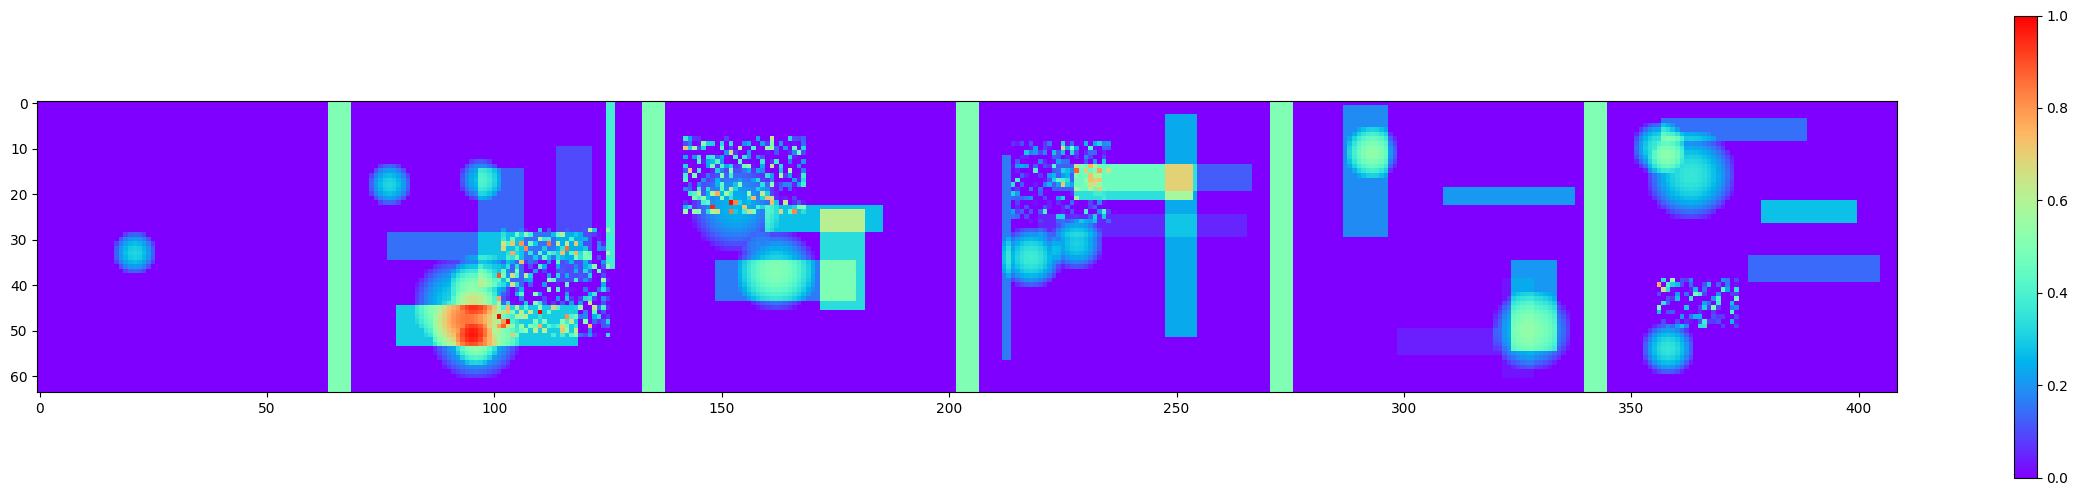

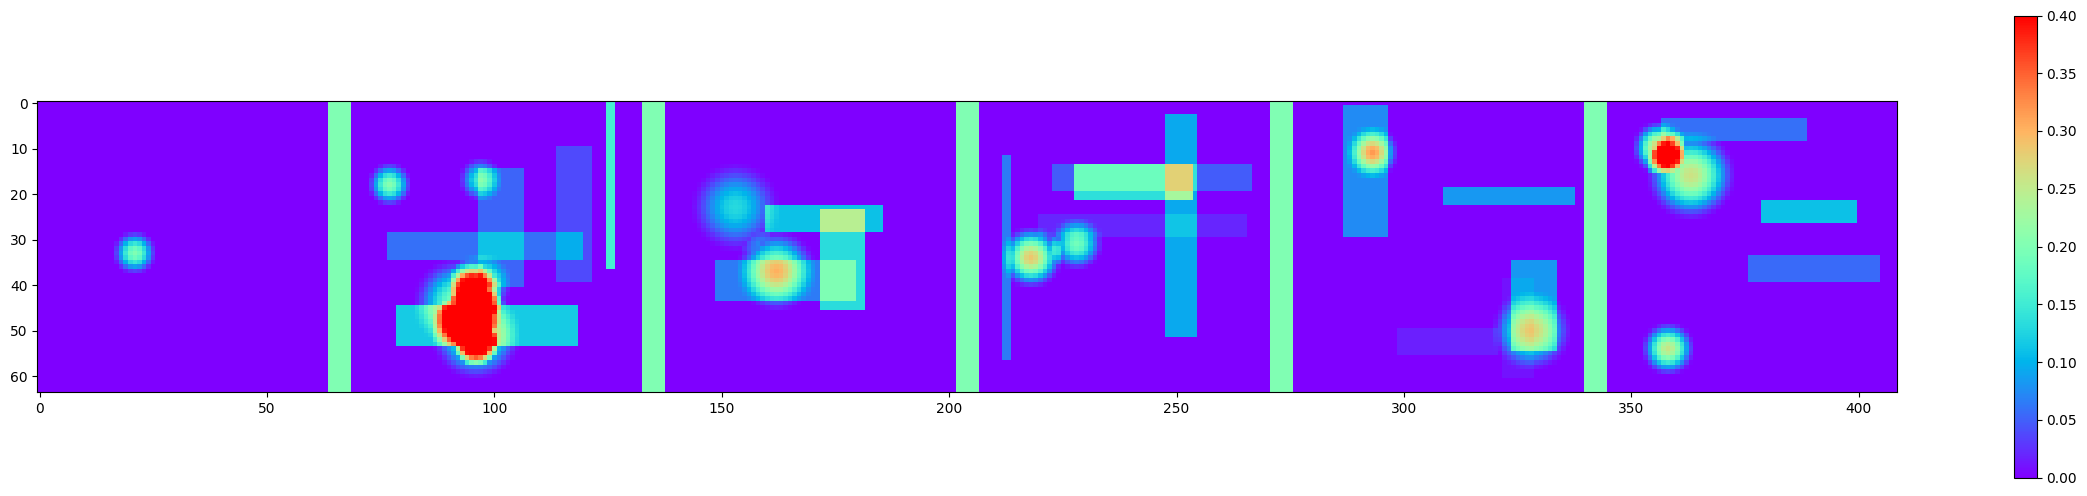

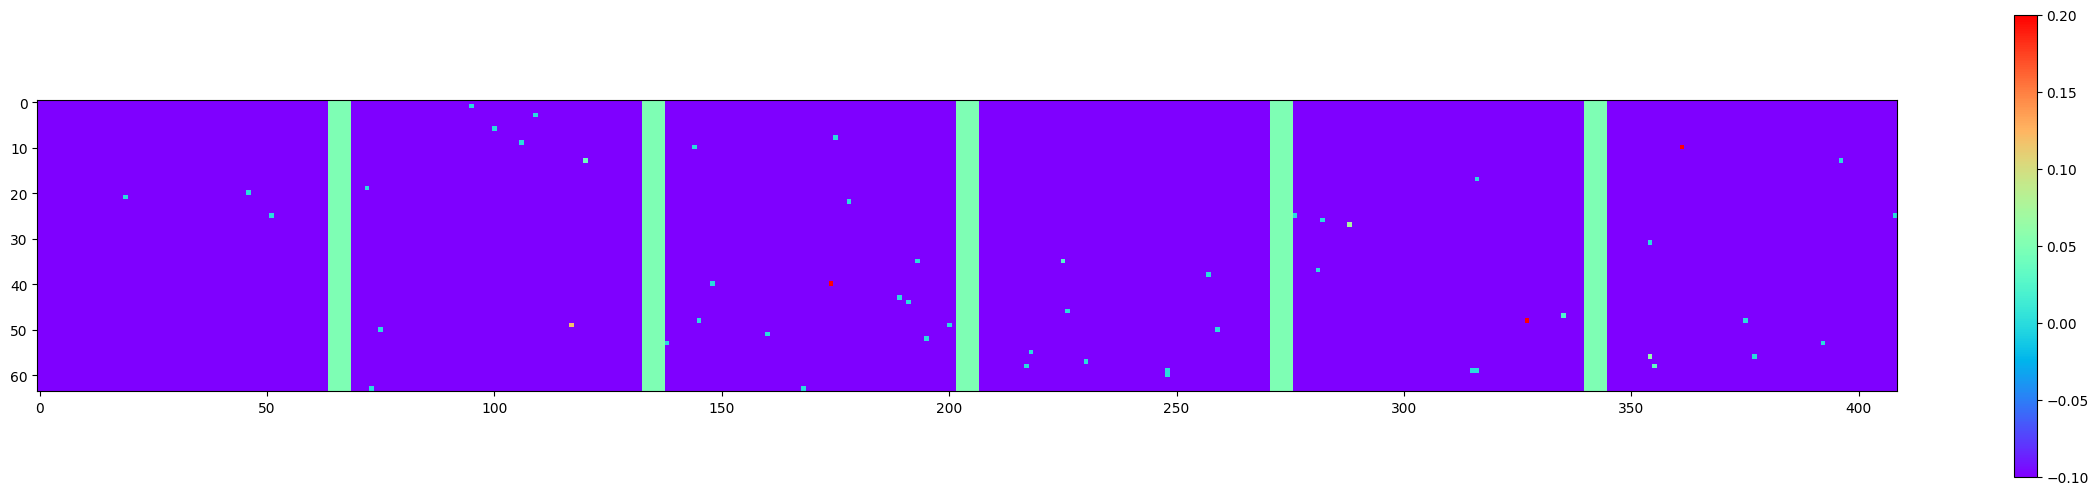

In [3]:
input,  target, fulltarget  = gen1(6,p=0.002)

# input: prédicteur spatialisé
fig0 = plt.figure(0, figsize=(30, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0, max_scale=1)

# fulltarget: cible complète, qu'on ne peut pas utiliser pour l'apprentissage
fig1 = plt.figure(1, figsize=(30, 6))
voir_batch2D(fulltarget, 6, fig1, k=0, min_scale=0, max_scale=0.4)

# target: cible incomplète
fig2 = plt.figure(2, figsize=(30, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=-0.1, max_scale=0.2)

**Q1** Pour entraîner un réseau de neurones sur des cibles incomplètes, on définit la fonction de coût *masked_MAE*.
Préciser le rôle du tenseur *mask*. Tester le bon fonctionnement de *masked_MAE* à l'aide d'un batch généré par *gen1*.
       




Le rôle du tenseur mask : Le tenseur mask dans masked_MAE est utilisé pour identifier les pixels au niveau desquels les observations ponctuelles sont disponibles.

Ainsi MAE est calculée uniquement pour les pixiels dont les observations ponctuelles sont disponibles tout en ignorant les pixels dont les observations sont manquantes


In [4]:
def masked_MAE(output, target, mask):
  return (torch.abs(output-target))[mask].mean()

In [13]:
input,  target, fulltarget  = gen1(6,p=0.002)



mask = target != -1

# Simulation d'une sortie du modèle (output) pour le test
output = fulltarget

# Calcul de la MAE masquée
mae = masked_MAE(output, target, mask)
mae

tensor(0.)

**Q2** Pour cette tâche de régression, nous allons entraîner un UNet. Précisez les différentes couches contenues dans ce UNet, leur rôle et le nombre de poids total qu'il contient.

In [5]:
fcn = UNet(1,1,16)

In [7]:
# Pour voir les noms des couches contenues dans UNEt
for module in fcn.modules():
    print(module.__class__.__name__)

UNet
inconv
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
outconv
Conv2d
outconv
Conv2d


In [9]:
#Le nombre total de poids qu'il contient
nb_weights = 0
for module in fcn.modules():
  # On compte les poids des couches qui en contiennent (attention aux doublons!):
  if isinstance(module, nn.Conv2d)\
    or isinstance(module, nn.BatchNorm2d)\
    or isinstance(module, nn.ConvTranspose2d):
    print(module.__class__.__name__)
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)
print("nb de poids : " + str(nb_weights))

Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
ConvTranspose2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
ConvTranspose2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
ConvTranspose2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
ConvTranspose2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
Conv2d
nb de poids : 926786


Le nombre total de poids est : 926786

**Q3** Dans la fonction *run_train* coder une époque de l'entraînement du UNet en exploitant la cible incomplète. Rester sur CPU. **Commenter votre code**. \
On utilisera les hyperparamètres suivants :

In [18]:
# optim: Adam, lr = 0.001
# batch par époque: 50
# taille d'un batch: 64
# p = 0.002

#Definition de l'optimizer
optimizer = optim.Adam(fcn.parameters(), lr=0.001)


In [17]:
def run_train(fcn, optimizer, p = 0.002):
    # Le modèle en mode entraînement
    fcn.train()  # Mettre le modèle en mode entraînement

    # Paramètres de l'entraînement
    nbatches = 50
    batch_size = 64

    for i in range(nbatches):
        #Load inputs
        input, target, fulltarget = gen1(batch_size, p=p)

        #Zeroing grad
        optimizer.zero_grad()
        # Cmask
        mask = target != -1

        # output of fcn
        output = fcn(input)

        # Compute loss
        loss = masked_MAE(output, target, mask)

        # Backpropagation et optimisation

        loss.backward()        # Calculer les gradients
        optimizer.step()       # Mettre à jour les poids


    return fcn, optimizer

In [19]:
import time
t = time.time()
run_train(fcn, optimizer, p = 0.002)
print(time.time() - t)

82.71947312355042


**Q4** Dans la fonction *run_train_gpu*, passer la phase d'entraînement sur GPU. Evaluer le speed-up.

In [23]:
fcn.cuda()  # Déplacer le modèle sur GPU


UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): Down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32

In [24]:
def run_train_gpu(fcn, optimizer, p=0.002):
    # Le modèle en mode entraînement
    fcn.train()


    # Paramètres de l'entraînement
    nbatches = 50
    batch_size = 64

    for i in range(nbatches):
        # Load inputs
        input, target, fulltarget = gen1(batch_size, p=p)
        input = input.cuda()  # Déplacer les données sur GPU
        target = target.cuda()  # Déplacer les cibles sur GPU

        # Zeroing gradient
        optimizer.zero_grad()

        # Créer un masque pour les données valides
        mask = (target != -1).cuda()

        # output of fcn
        output = fcn(input)

        # Compute loss
        loss = masked_MAE(output, target, mask)

        # Backpropagation et mise à jour des poids
        loss.backward()
        optimizer.step()

    return fcn, optimizer


In [25]:
# pour le calcul du speed-up
import time
t = time.time()
run_train_gpu(fcn, optimizer, p = 0.002)
print(time.time() - t)

5.812427520751953


In [26]:
#Evaluation du speed up
temps_cpu = 82.71947312355042
temps_gpu = 5.812427520751953

# Calcul du speed-up
speed_up = temps_cpu / temps_gpu
speed_up

14.231484664233543

Dans les questions suivantes, nous allons chercher à évaluer l'effet de la densité des observations ponctuelles *p* sur les performances en généralisation au cours de l'entraînement.

**Q5**  Pour comparer les performances en généralisation au cours de l'entraînement, on se permet d'utilise la MAE entre outputs et cibles **complètes**. En général, peut-on se permettre d'utiliser les mêmes données que celles qui ont été utilisées pendant la phase d'entraînement ? Est-ce le cas ici ? \
Dans la fonction *run_trainval_gpu()* suivante, évaluer les performances en généralisation au cours de l'entraînement (variable *epoch_MAE_validation*).
Eviter tout calcul superflux.

En général ,  l'utilisation des  mêmes données pour l'entraînement et l'évaluation des performances  peut conduire au surajustement (overfitting), où le modèle se performe bien sur les données d'entraînement mais échoue à généraliser sur des nouvelles données .

Pour notre cas , on utilise target pour l'entraînement et full_target pour l'évaluation

In [28]:
fcn.cuda()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): Down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32

In [29]:
def run_trainval_gpu(fcn, optimizer, p=0.002):
    # En mode entraînement
    fcn.train()


    nbatches = 50
    batch_size = 64
    epoch_loss = 0
    epoch_mae_validation = 0

    for i in range(nbatches):
        # Load inputs

        input, target, fulltarget = gen1(batch_size, p=p)
        input = input.cuda()
        target = target.cuda()
        fulltarget = fulltarget.cuda()

        # Zeroing gradient
        optimizer.zero_grad()

        # Créer un masque pour les données valides
        mask = (target != -1).cuda()

        # output of fcn
        output = fcn(input)

        # compute Loss entre output et cible
        loss = masked_MAE(output, target, mask)

        # Backpropagation et mise à jour des poids
        loss.backward()
        optimizer.step()

        # Cumulatuin de loss
        epoch_loss += loss.item()

        # Calculer la MAE sur full_target
        mae_validation = torch.mean(torch.abs(output - fulltarget)).item()
        epoch_mae_validation += mae_validation

    # Compute the mean
    epoch_loss /= nbatches
    epoch_mae_validation /= nbatches

    return fcn, optimizer, epoch_mae_validation




In [30]:
fcn, optimizer, MAE_validation = run_trainval_gpu(fcn, optimizer, p = 0.002)

**Q6** Générer deux versions du UNet précédent comportant les **mêmes poids initiaux**. Entraîner ces versions sur cinquante époques, chacun pour une valeur de *p* différente : *p* = 0.01 et *p* = 0.002.
**Commenter votre code**. Tracer et discuter les courbes d'apprentissage.

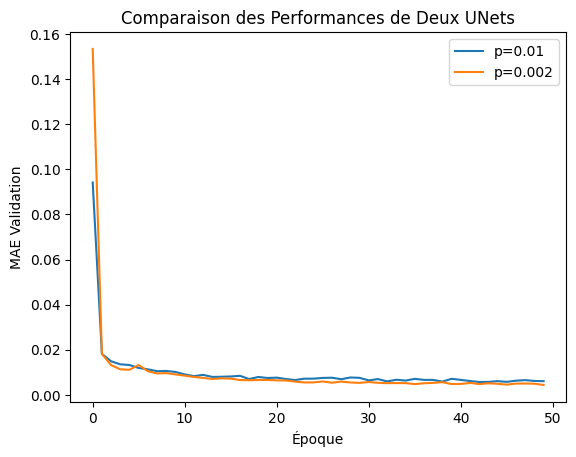

In [31]:



nepochs = 50
#Stocker les scores des deux modèles
scores_1 = []
scores_2 = []

# Le premier modèle
fcn = UNet(1, 1, 16)
fcn.cuda()
optimizer = optim.Adam(fcn.parameters(), lr=0.001)

# le deuxième modèle
fcn2 = UNet(1,1,16)
fcn2.cuda()
optimizer2 = optim.Adam(fcn2.parameters(), lr=0.001)


for epoch in range(nepochs):
    # Prmier modèle avec p=0.01
    fcn, optimizer, mae_validation = run_trainval_gpu(fcn, optimizer, p=0.01)
    scores_1.append(mae_validation)

    # Deuxième modèle avec p=0.002
    fcn2, optimizer2, mae_validation2 = run_trainval_gpu(fcn2, optimizer2, p=0.002)
    scores_2.append(mae_validation2)

#tracage des courbes d'apprentissage
import matplotlib.pyplot as plt

plt.plot(range(nepochs), scores_1, label='p=0.01')
plt.plot(range(nepochs), scores_2, label='p=0.002')
plt.xlabel('Époque')
plt.ylabel('MAE Validation')
plt.title('Comparaison des Performances de Deux UNets')
plt.legend()
plt.show()


Commentaires:

Après la convergence initiale, les courbes restent stables, indiquant que les modèles ne surajustent pas significativement les données d'entraînement.
Même avec une proportion plus faible d'observations ponctuelles p = 0.002, le modèle est toujours capable de faire des prédictions précises.

**Q7** Combien faut-il d'époques supplémentaires au deuxième *fcn* pour rattraper le premier ?

## **Partie II** : cas où les observations ponctuelles peuvent aussi servir d'entrées.

Dans cette partie, nous supposons que les observations ponctuelles sont disponibles non seulement pendant l'apprentissage, mais aussi en phase d'inférence.
Il devient donc possible de l'utiliser comme une entrée.

Avec la fonction *gen2*, cela va même s'avérer nécessaire : les observations ponctuelles contiennent une information essentielle à la prédiction de la cible complète.

En effet, le premier tenseur founi par *gen2* (ligne 1 ci-dessous) permet de dire où sont les pixels associés à des valeurs non nulles dans la cible complète (ligne 2).
Par contre, ce premier tenseur ne suffit pas à préciser l'intensité du signal cible : pour certaines cellules (premier type de cellules, en rouge sur la troisième ligne) le signal cible est plus fort que sur le premier tenseur, alors que pour d'autres cellules (deuxième type de cellule, en cyan), il est plus faible. Et rien dans le premier tenseur n'indique à quel type de cellule on a affaire.

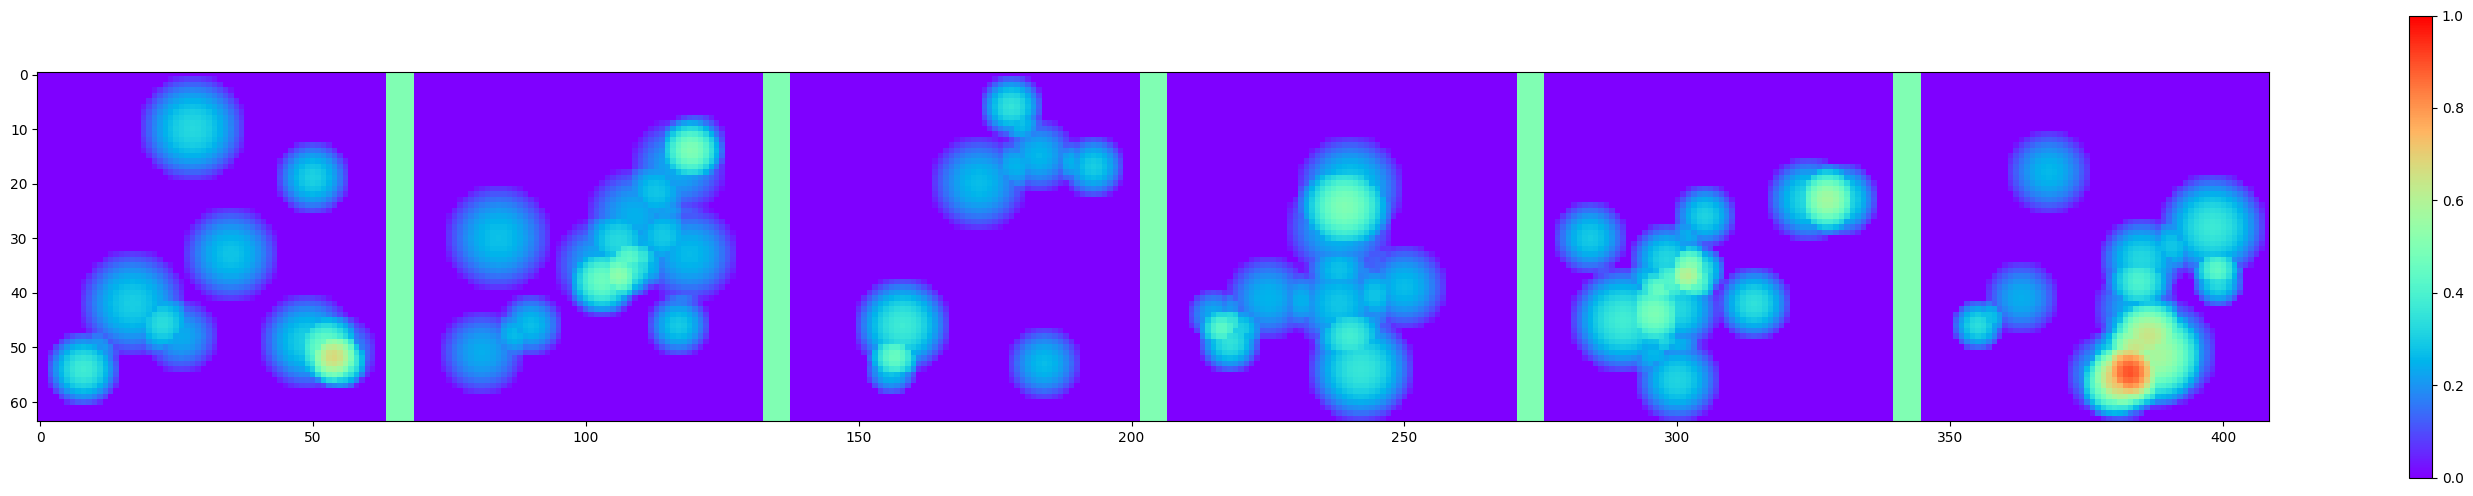

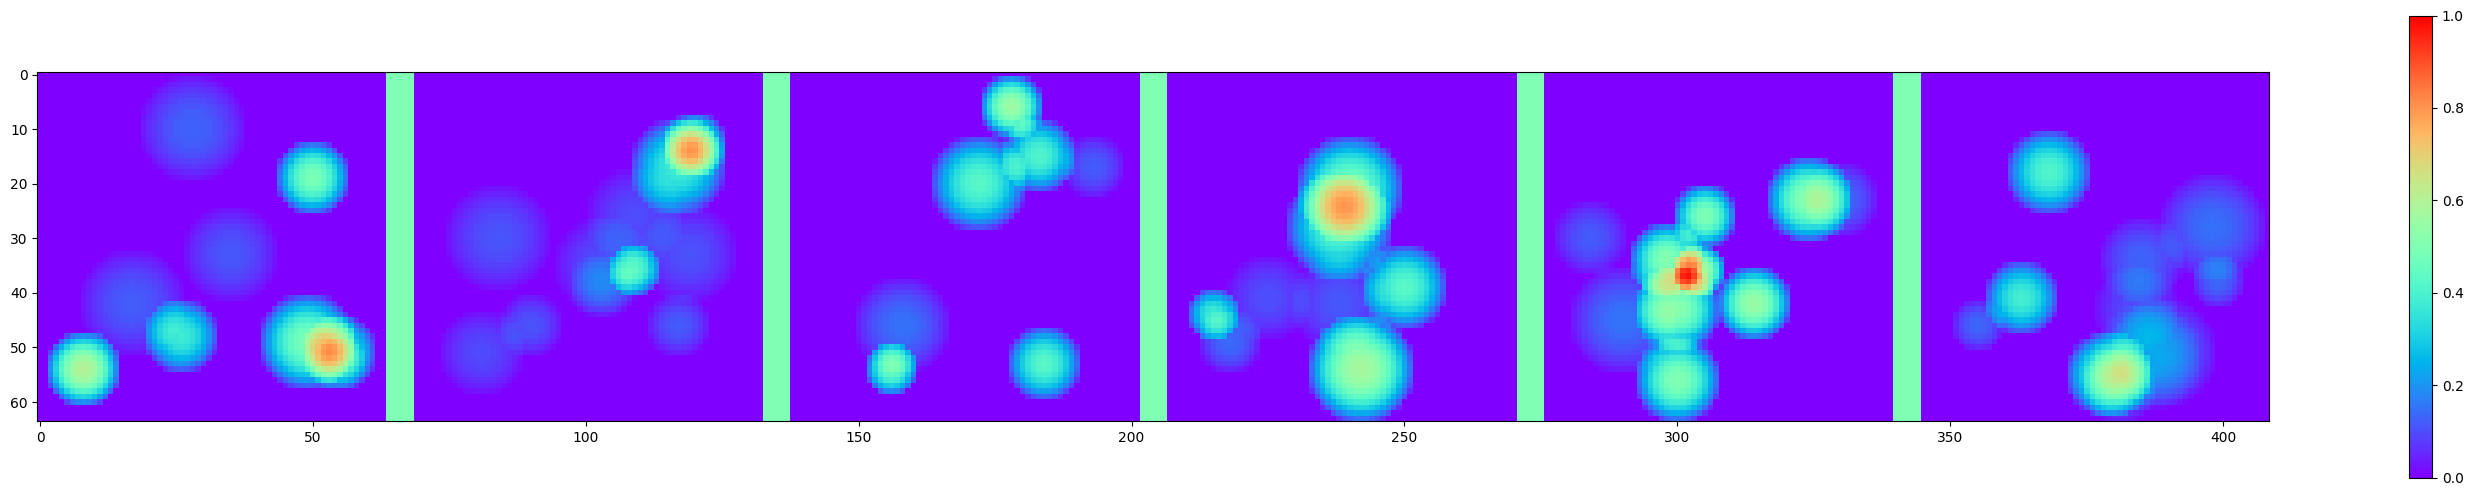

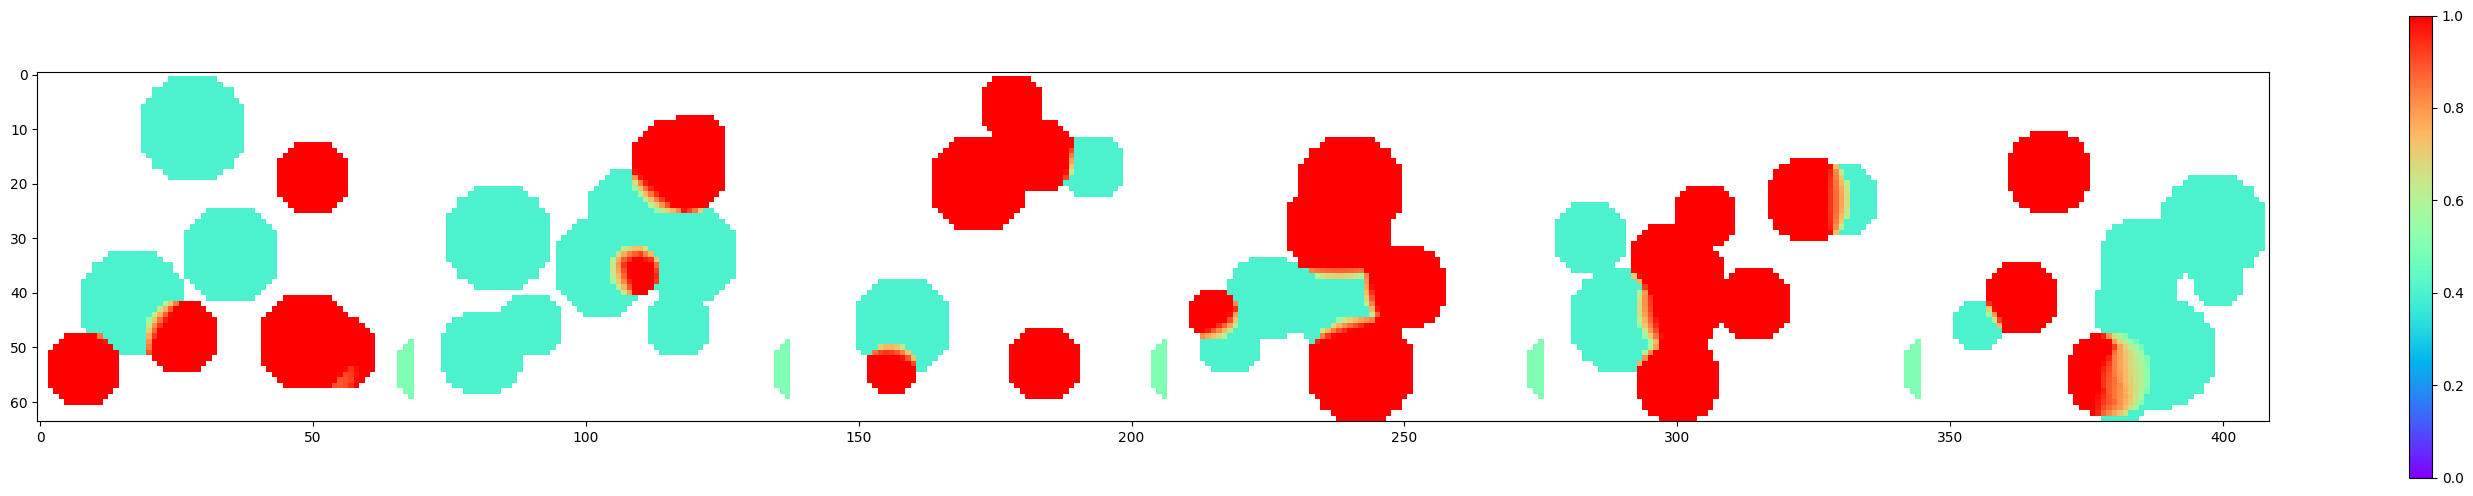

In [32]:
input, target, fulltarget  = gen2(6,0.01)

# ligne 1: le prédicteur spatialisé
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ligne 2: le signal cible complet où les deux types de cellules apparaissent
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(fulltarget, 6, fig1, k=0, min_scale=0,max_scale=1)

# ligne 3: le rapport entre les deux
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D((fulltarget/input), 6, fig1, k=0, min_scale=0,max_scale=1)

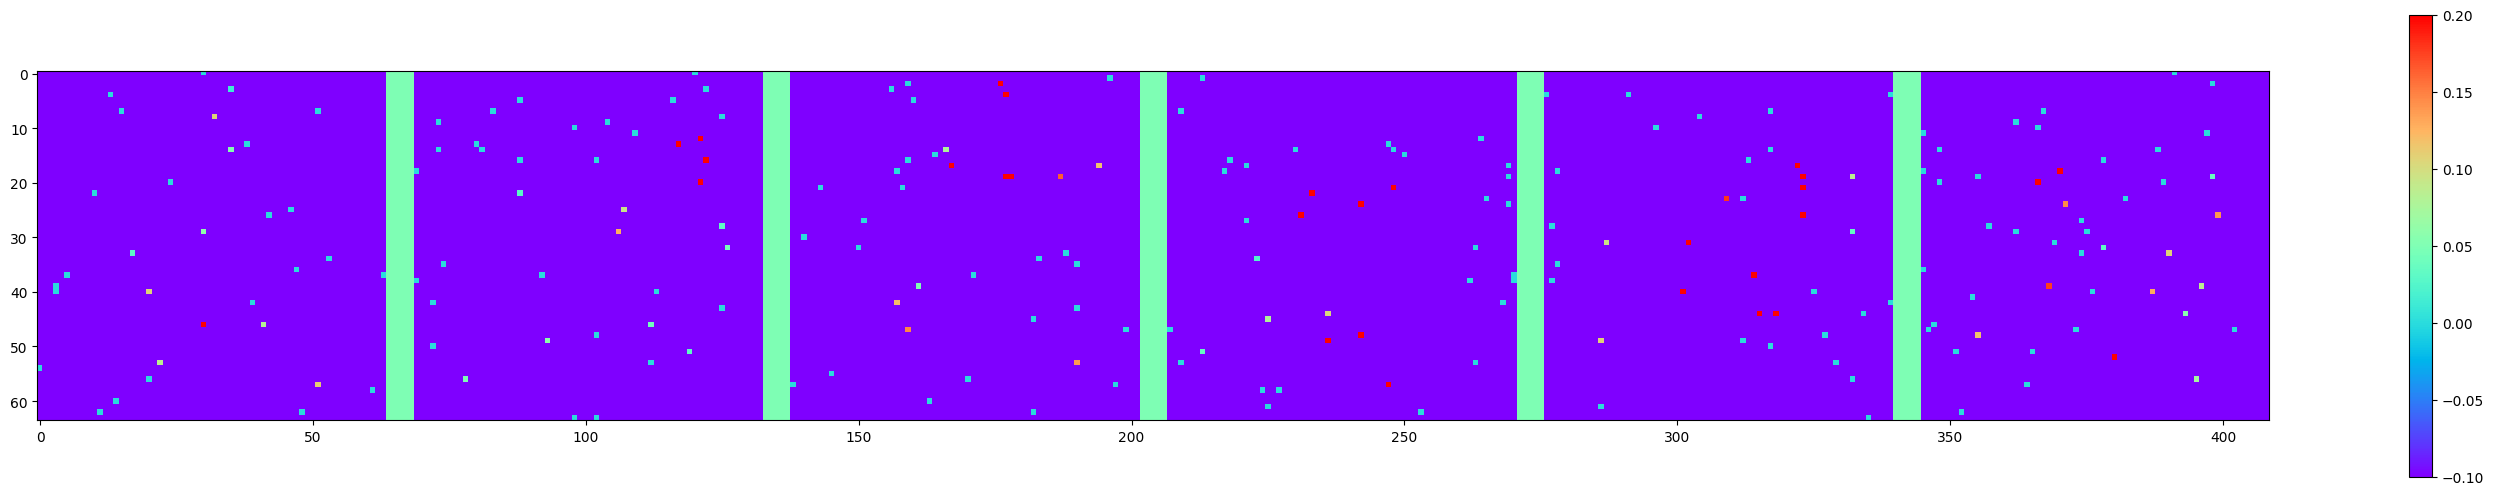

In [33]:
# les observations ponctuelles:
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=-0.1,max_scale=0.2)

Comme dans la partie I, les observations ponctuelles sont les seules parties de la cible disponibles au cours de l'entraînement. Mais, comme expliqué au-dessus, ces observations ponctuelles seront aussi disponibles en phase d'inférence. Comme elles contiennent une information essentielle, il va donc s'agir d'entraîner le réseau à les exploiter à la fois comme cibles et comme entrées.


**NB:** De même que dans la partie I, dans le deuxième tenseur les valeurs manquantes sont codées par -1 et toutes les autres valeurs sont positives ou nulles.

**Q1** Dans un premier temps, entraîner un UNet **en n'utilisant que le premier tenseur ("input") en entrée**. Toutes les observations ponctuelles disponibles peuvent être utilisées dans la cible.
Les autres consignes sont :
- Choisir la fonction de coût de manière à estimer la **moyenne conditionnelle à l'entrée**.
- Pour la phase de validation, évaluer l'écart entre la cible complète et les outputs de la phase d'entraînement (comme dans la partie I).
- Utiliser les hyperparamètres ci-dessous:

In [34]:
import torch.optim as optim
fcn = UNet(1,1,16)
nepochs = 15
nbatches = 100
batchsize = 64
p = 0.01

In [35]:
fcn.cuda()
optimizer = optim.Adam(fcn.parameters(), lr=0.001)

In [36]:
scores_1  = []

for epoch in range(nepochs):

    for _ in range(nbatches):
        # load input
        input, target, fulltarget = gen2(batchsize, p)
        input = input.cuda()
        target = target.cuda()
        fulltarget = fulltarget.cuda()


        optimizer.zero_grad()
        output = fcn(input)
        #Calcul de MAE
        loss = torch.mean(torch.abs(output - target))
        loss.backward()
        optimizer.step()

    # Partie de validation
    with torch.no_grad():
        fcn.eval()
        output = fcn(input)
        mae_validation = torch.mean(torch.abs(output - fulltarget)).item()
        scores_1.append(mae_validation)
        fcn.train()

# Les scores
print(scores_1)


[0.6352831721305847, 1.042963981628418, 1.0597097873687744, 1.0530757904052734, 1.0706185102462769, 1.0723425149917603, 1.043172001838684, 1.0571904182434082, 1.052322268486023, 1.053081750869751, 1.0685206651687622, 1.0697022676467896, 1.063407301902771, 1.0578556060791016, 1.06798255443573]


**Q2** Pourquoi les performances stagnent-elles ? Visualiser quelques outputs et vérifier que le réseau restitue simplement le champ d'entrée. Expliquer pourquoi, intuitivement.

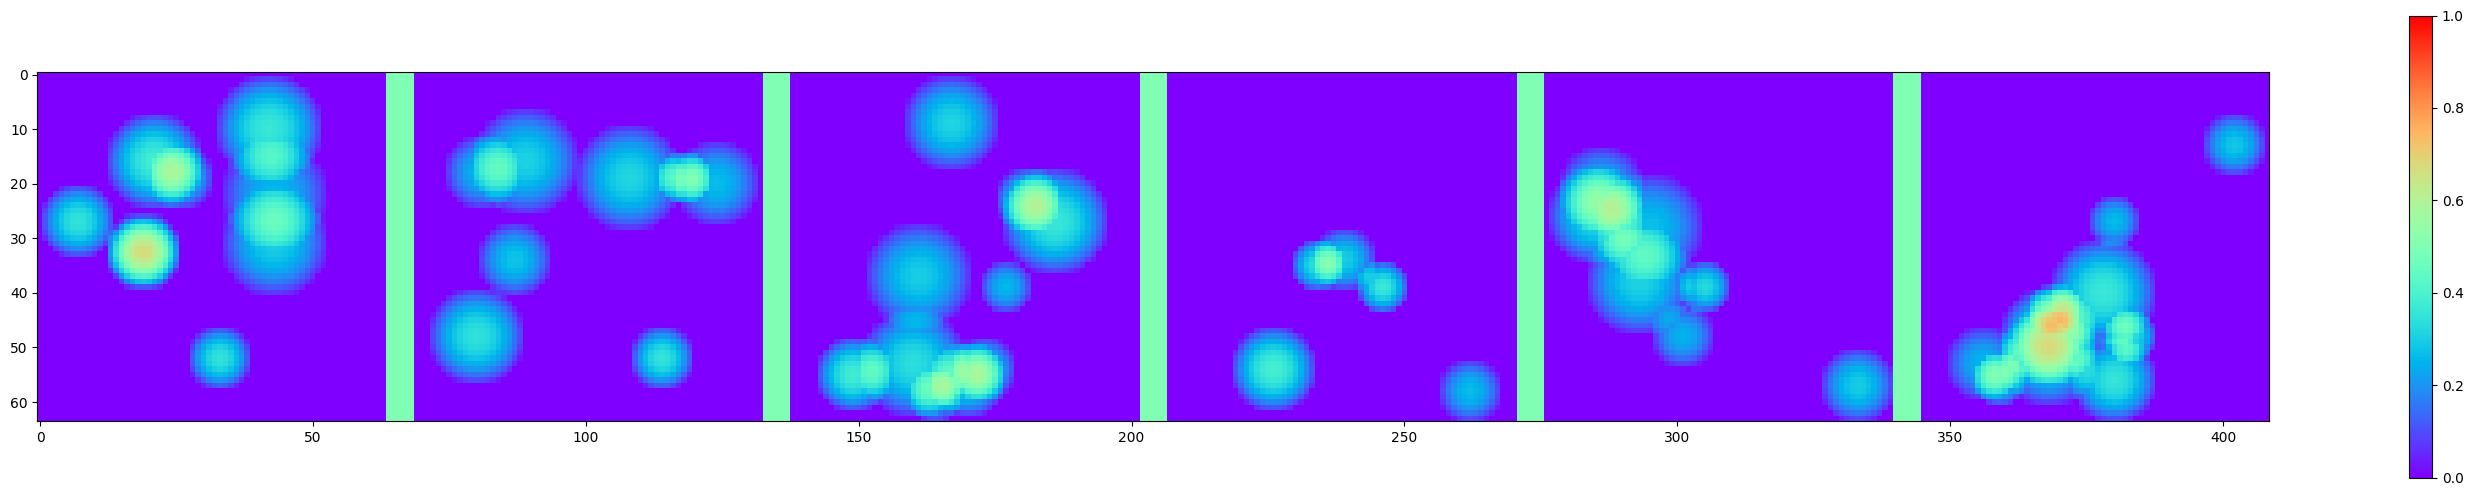

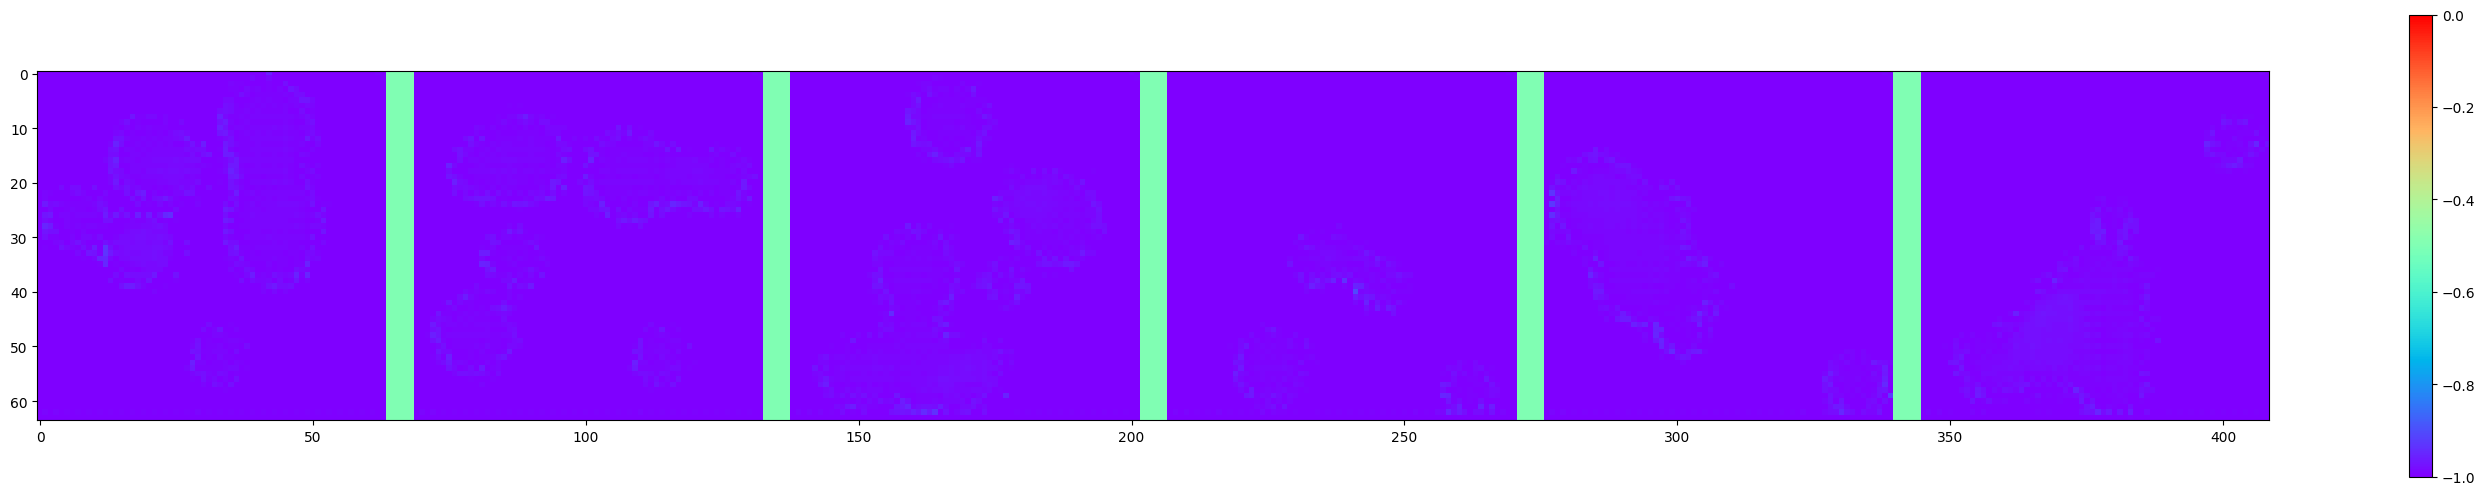

In [41]:


# Mettre le modèle en mode évaluation.
fcn.eval()

#Load inputs
p = 0.01
input, target, fulltarget = gen2(batch_size, p)

# Output of fcn
output = fcn(input.cuda())



# Créer les figures pour l'affichage.
fig = plt.figure(figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)

fig1 = plt.figure(figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig1, k=0, min_scale=-1, max_scale=0)

plt.show()







Commentaire : Les outputs ressemblent étroitement au champ d'entrée sans capturer de nouvelles informations utiles pour prédire la full_target , le réseau restitue simplement le champ d'entrée, il est en surajustement sur les observations ponctuelles disponibles ce qui est cohérent avec la question précédente puisque les performances stagnent

On peut donc dire que le réseau n'a pas appris à extrapoler ou à interpréter efficacement les données incomplètes pour reconstruire la cible complète


On cherche maintenant à utiliser une partie des observations ponctuelles comme prédicteurs.\
Une idée simple consiste à définir un deuxième tenseur d'entrée ne comptant (environ) qu'une observation ponctuelle sur deux. Les autres observations ponctuelles sont quant elles utilisées comme cible.

**Q3** Mettre en oeuvre cette idée.

**Remarques:**
- La fonction *torch.bernoulli* permet de masquer environ 50% des valeurs d'un tenseur...
- Attention à la mutabilité des tenseurs pytorch.

In [43]:


# Le nv tenseur d'entrée comptant 50ù des observations ponstuelles
input_partial = input *torch.bernoulli(0.5 * torch.ones_like(target))

# ULe reste des observations est utilisé comme target
target_partial = target * (1 - torch.bernoulli(0.5 * torch.ones_like(target)))


**Q4** Procéder à un apprentissage sur dix époques, comparer la courbe d'apprentissage obtenue avec la précédente et expliquer.

In [45]:
# Hyperparamètres
nepochs = 10
batchsize = 64
p = 0.01

# Modele en gpu
fcn = UNet(2, 1, 16).cuda()

# Optimizer
optimizer = optim.Adam(fcn.parameters(), lr=0.001)

In [49]:

# Entraînement sur les époques
for epoch in range(nepochs):
    for _ in range(nbatches):
        # Charger les données
        input, target, fulltarget = gen2(batchsize, p)
        input = input.cuda()
        target = target.cuda()
        fulltarget = fulltarget.cuda()

        # Créer le tenseur d'entrée partiel avec 50% des observations ponctuelles
        input_partial = input * torch.bernoulli(0.5 * torch.ones_like(target))

        # Le reste des observations est utilisé comme target
        target_partial = target * (1 - torch.bernoulli(0.5 * torch.ones_like(target)))

        # Concaténer input_partial et input
        new_input = torch.cat((input_partial, input), dim=1)

        # Zeroing gradient
        optimizer.zero_grad()

        # output
        output = fcn(new_input)

        # Calcul de la MAE
        loss = torch.mean(torch.abs(output - target_partial))

        # Rétropropagation
        loss.backward()

        # Mise à jour des poids
        optimizer.step()

    # Validation
    with torch.no_grad():
        fcn.eval()
        output = fcn(new_input)
        mae_validation = torch.mean(torch.abs(output - fulltarget)).item()
        scores_2.append(mae_validation)
        fcn.train()

# Les scores
print(scores_2)

[0.1533337665721774, 0.018178210146725177, 0.013209015801548958, 0.011351038478314876, 0.011141986958682537, 0.013260915875434875, 0.010491069816052913, 0.009524219390004873, 0.009669967796653509, 0.009074911512434482, 0.00852855428121984, 0.007983456552028655, 0.007525466959923506, 0.007052498096600175, 0.00732630543410778, 0.00722156741656363, 0.006599478786811232, 0.006515842135995626, 0.006592865791171789, 0.006652762861922384, 0.006440097065642476, 0.006395688289776444, 0.00589896927587688, 0.005526086110621691, 0.005545486761257053, 0.005957786412909627, 0.005402031820267439, 0.005919750034809113, 0.005507886214181781, 0.005324912453070283, 0.005729898503050208, 0.0053534653317183255, 0.00519969567656517, 0.005256411535665393, 0.0052286872081458565, 0.004782005320303142, 0.005163475177250802, 0.005340924123302102, 0.005632346644997597, 0.004823446571826935, 0.004864232316613197, 0.00531718757469207, 0.004796670568175614, 0.005150248990394175, 0.004924143715761602, 0.0045613924367

**Q5** Visualiser des batches d'outputs. Dans quelle mesure le réseau parvient-il à lever l'ambiguïté sur le type de cellule en présence ?

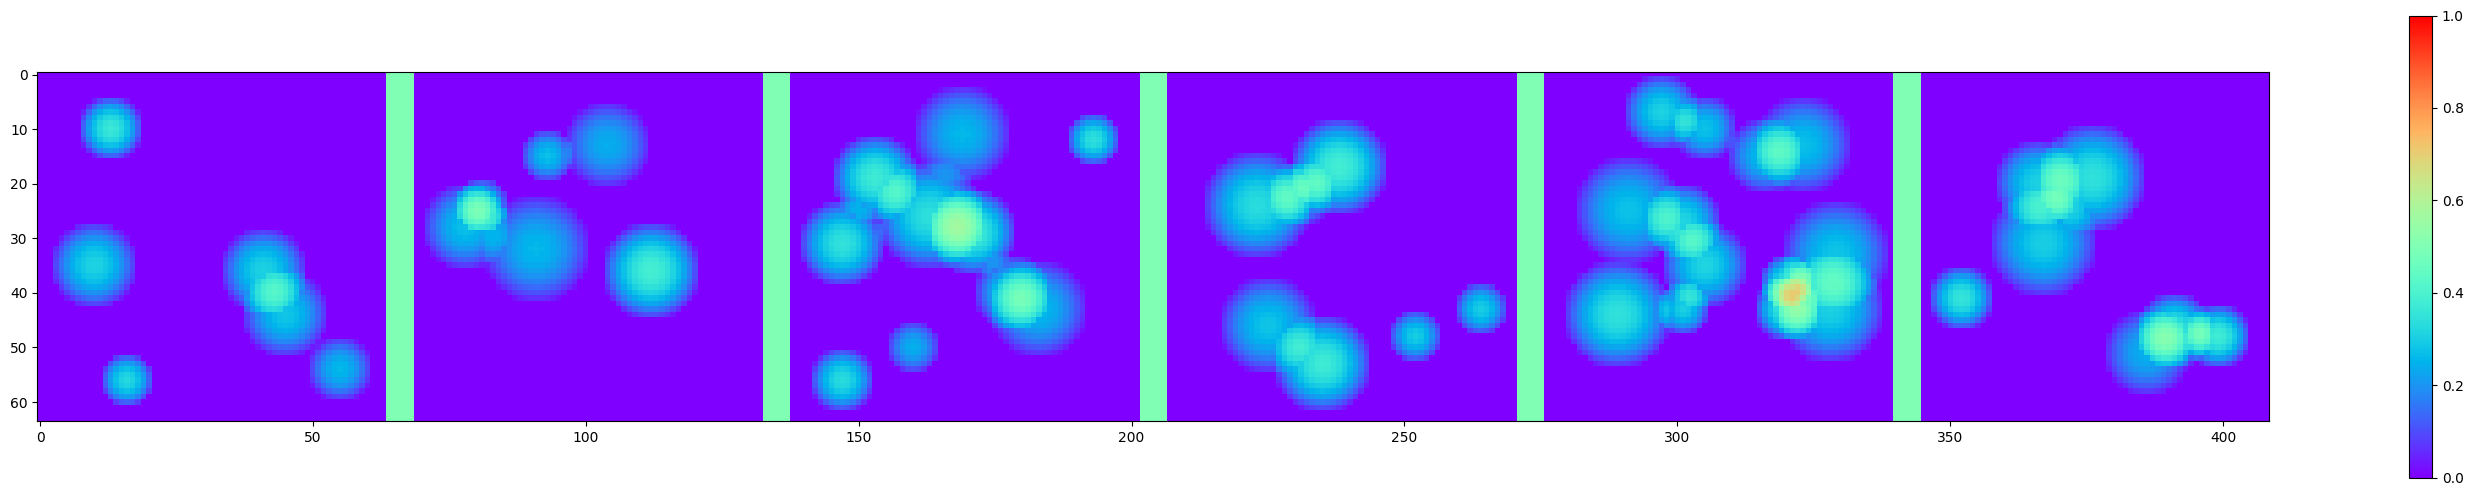

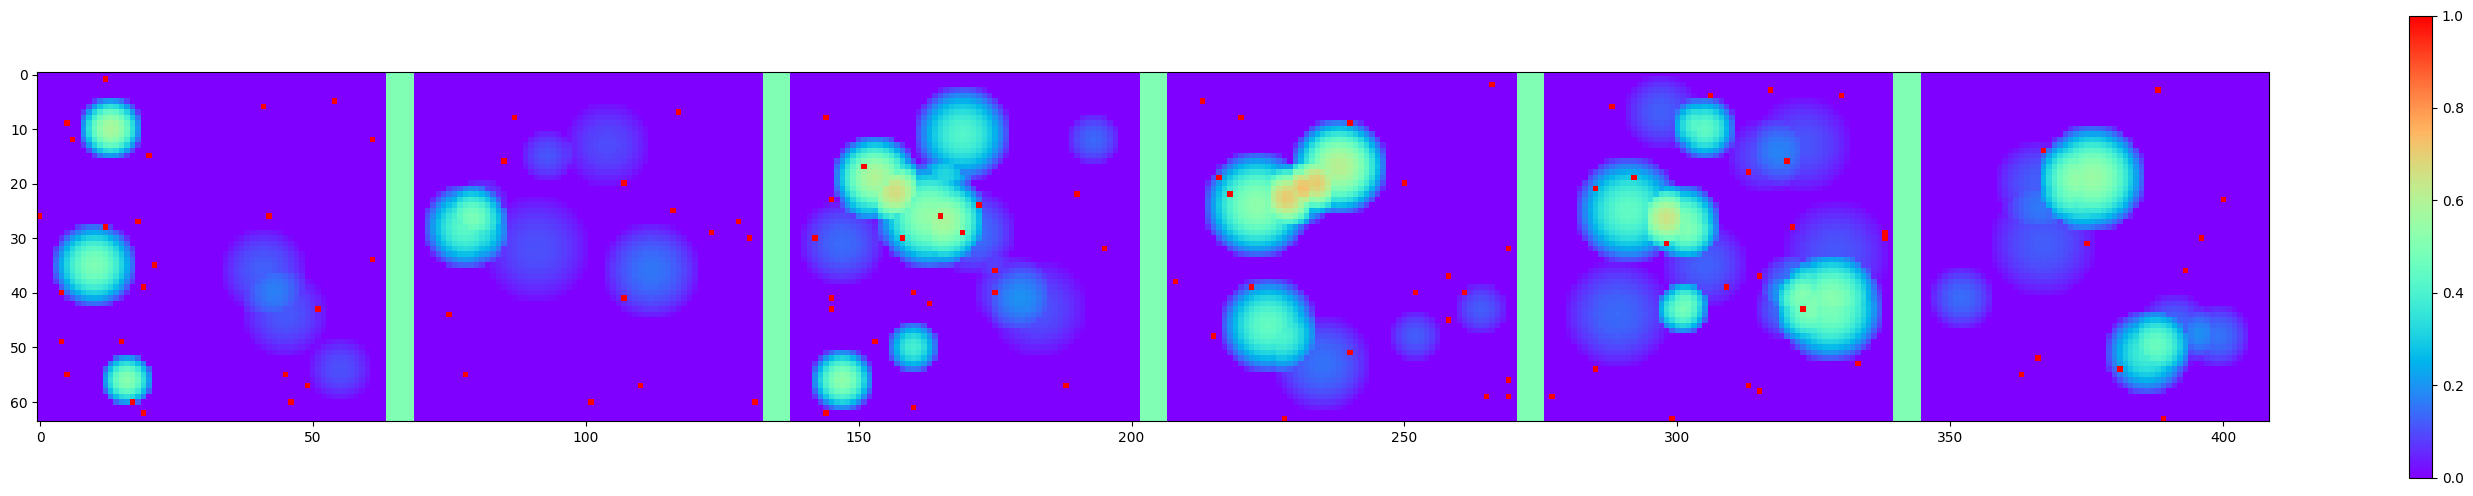

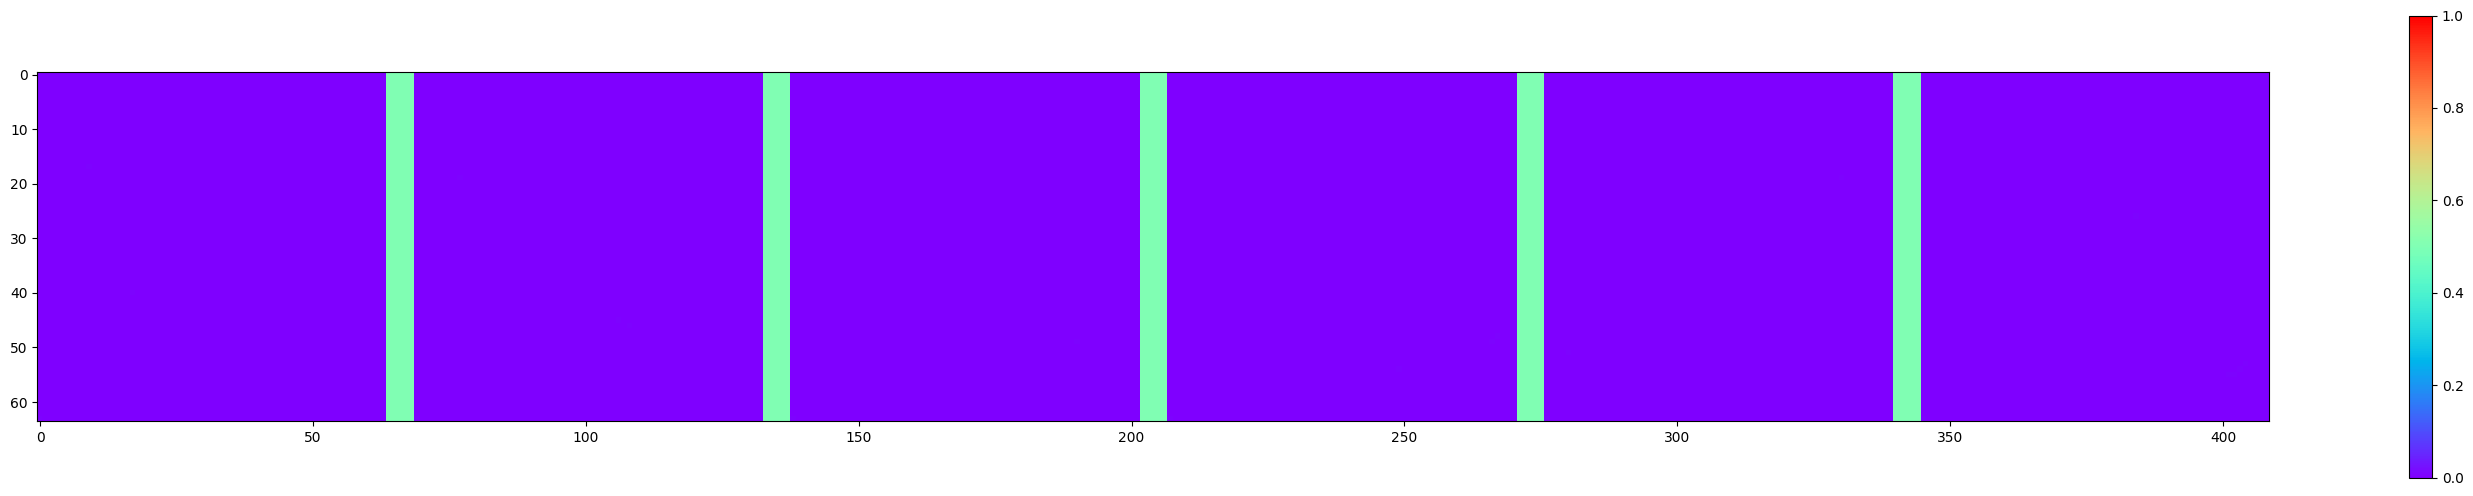

In [50]:
fcn.eval()
input,  target, fulltarget  = gen2(6, p = 0.005)

# prédicteur spatialisé
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# obs ponctuelles et cible complète
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D((target>=0) + fulltarget, 6, fig1, k=0, min_scale=0.,max_scale=1)

mask = torch.bernoulli(0.5 * torch.ones_like(target))
input_partial = input * mask
new_input = torch.cat((input_partial, input), dim=1)
output = output = fcn(new_input.cuda())

#les output
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0, max_scale=1)

**Q6** Au cours d'un apprentissage, nous avons utilisé (environ) la moitié des observations ponctuelles à disposition. Quel peut être le défaut de cette approche ? Jouer sur la valeur de *p* pour illustrer votre propos.

Si la valeur de p est trop faible , cela signifie que très peu d'observations ponctuelles sont utilisées comme prédicteurs, tandis que la majorité est utilisée comme cible. Dans ce cas, le réseau n'apprendra pas suffisamment à partir des observations ponctuelles

En revanche, si la valeur de p est proche de 1, cela signifie que la plupart des observations ponctuelles sont utilisées comme prédicteurs, le réseau peut surapprendre les données d'entraînement.

**Q7** Pour prédire la valeur d'un pixel, un FCN permet de prendre en compte le contexte, c'est à dire l'information contenue dans un large voisinage autour du pixel d'intérêt.\
Cette qualité était-elle nécessaire pour traiter la **partie I** du problème ? Etait-elle nécessaire pour traiter la **partie II** ? Justifier dans les deux cas.